In [30]:
import torch
import pandas as pd
import numpy as np

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [31]:
lap_times = pd.read_csv('../dataset/lap_times.csv')
pit_stops = pd.read_csv('../dataset/pit_stops.csv')[['raceId', 'driverId', 'lap']]
races = pd.read_csv('../dataset/races.csv')[['raceId', 'circuitId']]

In [33]:
#Data Preprocessing

lap_times = lap_times.merge(races, on='raceId', how='left')
lap_times['normalized_time'] = lap_times['milliseconds'] / lap_times.groupby('raceId')['milliseconds'].transform('min')
lap_times = lap_times.merge(pit_stops[['raceId', 'driverId', 'lap']], on=['raceId', 'driverId', 'lap'], how='left', indicator=True)
lap_times['is_pit_stop'] = (lap_times['_merge'] == 'both').astype(int)
lap_times.drop(columns=['_merge'], inplace=True)
lap_times['is_pit_exit'] = lap_times['is_pit_stop'].shift(1, fill_value=0)
# Example: Filter out laps with normalized_time > 1.5 (assuming it's an anomaly)
lap_times = lap_times[lap_times['normalized_time'] <= 1.5]
lap_times.head()

,raceId,driverId,lap,position,time,milliseconds,circuitId_x,normalized_time,is_pit_stop,is_pit_exit,circuitId_y
0,841,20,1,1,1:38.109,98109,1,1.103005,0,0,1
1,841,20,2,1,1:33.006,93006,1,1.045634,0,0,1
2,841,20,3,1,1:32.713,92713,1,1.042340,0,0,1
3,841,20,4,1,1:32.803,92803,1,1.043352,0,0,1
4,841,20,5,1,1:32.342,92342,1,1.038169,0,0,1


In [34]:
X = torch.tensor(lap_times.drop(columns=["normalized_time", "time"], axis=1).to_numpy(), dtype=torch.float)
y = torch.tensor(lap_times["normalized_time"].to_numpy(), dtype=torch.float)

# Verify X, y value
print("Input tensors: ", X[:5], "\n")
print("Output tensors: ", y[:5], "\n\n")

print("Shape of input tensor: ", X.shape)
print("Shape of ouput tensor: ", y.shape)

Input tensors:  tensor([[8.4100e+02, 2.0000e+01, 1.0000e+00, 1.0000e+00, 9.8109e+04, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00],
        [8.4100e+02, 2.0000e+01, 2.0000e+00, 1.0000e+00, 9.3006e+04, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00],
        [8.4100e+02, 2.0000e+01, 3.0000e+00, 1.0000e+00, 9.2713e+04, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00],
        [8.4100e+02, 2.0000e+01, 4.0000e+00, 1.0000e+00, 9.2803e+04, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00],
        [8.4100e+02, 2.0000e+01, 5.0000e+00, 1.0000e+00, 9.2342e+04, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00]]) 

Output tensors:  tensor([1.1030, 1.0456, 1.0423, 1.0434, 1.0382]) 


Shape of input tensor:  torch.Size([558132, 9])
Shape of ouput tensor:  torch.Size([558132])


In [35]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, test_size=0.5, random_state=42)

# Shape of dataset before split

print("Shape of input tensor: ", X.shape)
print("Shape of ouput tensor: ", y.shape, "\n")

# Shape of train, val, and test dataset after split. The sum total is same as original dataset. 
# And each dataset still has 6 features which is the expected result

print("Train input: ", X_train.shape, "Train output: ", y_train.shape)
print("Val input: ", X_val.shape, "Val output: ", y_val.shape)
print("Test input: ", X_test.shape, "Test output: ", y_test.shape)

Shape of input tensor:  torch.Size([558132, 9])
Shape of ouput tensor:  torch.Size([558132]) 

Train input:  torch.Size([446505, 9]) Train output:  torch.Size([446505])
Val input:  torch.Size([55813, 9]) Val output:  torch.Size([55813])
Test input:  torch.Size([55814, 9]) Test output:  torch.Size([55814])


In [36]:
# Calculate mean
mean_train = X_train.mean(dim=0)
mean_val = X_val.mean(dim=0)
mean_test = X_test.mean(dim=0)

# Calculate standard deviation
std_train = X_train.std(dim=0)
std_val = X_val.std(dim=0)
std_test = X_test.std(dim=0)

# apply mean and std to the input dataset
X_train = (X_train - mean_train)/ std_train
X_val = (X_val - mean_val)/ std_val
X_test = (X_test - mean_test)/ std_test

print("Normalized X_train: ", X_train[:5], "\n")
print("Normalized X_val: ",X_val[:5], "\n")
print("Normalized X_train: ",X_test[:5], "\n")

Normalized X_train:  tensor([[ 0.9957,  1.3440,  0.5256, -1.3859, -1.0375, -0.6456, -0.1317, -0.1316,
         -0.6456],
        [ 0.7127,  1.3049, -0.3484,  0.0621,  1.4896, -0.2053, -0.1317, -0.1316,
         -0.2053],
        [ 0.7452,  1.3205,  2.0005,  1.6910, -1.0107,  2.4854, -0.1317, -0.1316,
          2.4854],
        [ 1.1465, -0.8077,  0.6895, -0.4809, -0.9069, -0.6456, -0.1317, -0.1316,
         -0.6456],
        [-1.1708, -0.7399,  0.1979, -0.6619, -0.6728, -0.4988, -0.1317, -0.1316,
         -0.4988]]) 

Normalized X_val:  tensor([[-1.3287, -0.6429, -0.9442,  0.0577,  1.2448, -0.3008, -0.1333, -0.1312,
         -0.3008],
        [-1.3310, -0.7940,  0.2020, -0.1234,  0.5385, -0.3499, -0.1333, -0.1312,
         -0.3499],
        [-1.0734, -0.6872, -0.8350,  1.3252, -1.1675, -0.0063, -0.1333, -0.1312,
         -0.0063],
        [ 0.5973, -0.8097, -0.3438,  0.4198,  0.8502, -0.8408, -0.1333, -0.1312,
         -0.8408],
        [-1.2358, -0.7654, -1.2717,  0.4198, -1.0926, -0.

In [37]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# show how train_dataset looks like
print(train_dataset[0])

(tensor([ 0.9957,  1.3440,  0.5256, -1.3859, -1.0375, -0.6456, -0.1317, -0.1316,
        -0.6456]), tensor(1.0496))


In [38]:
# Creating dataloader for each train, val and test dataset
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset.tensors[0]), shuffle=False, drop_last=True)

# showing first batch of train_loader
for X, y in train_loader:
  print("Shape of first batch of train_loader input : ", X.shape)
  print("Shape of first batch of train_loader output : ", y.shape)
  break

Shape of first batch of train_loader input :  torch.Size([10, 9])
Shape of first batch of train_loader output :  torch.Size([10])


In [39]:
class fitbit_model(nn.Module):
  def __init__(self, input_features, output_class):
    super(fitbit_model, self).__init__()    
    self.layer1 = nn.Linear(in_features=input_features, out_features=64)
    self.activation1 = nn.ReLU()
    self.layer2 = nn.Linear(in_features=64, out_features=64)
    self.activation2 = nn.ReLU()
    self.layer3 = nn.Linear(in_features=64, out_features=32)    
    self.activation3 = nn.ReLU()
    self.output = nn.Linear(in_features=32, out_features=output_class)

  def forward(self, x):
    x = self.activation1(self.layer1(x))
    x = self.activation2(self.layer2(x))
    x = self.activation3(self.layer3(x))
    return self.output(x)


In [40]:
input_features = X_train.shape[1]
output_class = 1
model = fitbit_model(input_features, output_class)

print("Model Schema\n")
print(model)

print("\nModel initial weights values for layer1")
print(model.layer1.weight[:2])
print("Weight shape on layer1: ", model.layer1.weight.shape)

print("\nModel initial bias values for layer1")
print(model.layer1.bias[:2])
print("Bias shape on layer1: ", model.layer1.bias.shape)


Model Schema

fitbit_model(
  (layer1): Linear(in_features=9, out_features=64, bias=True)
  (activation1): ReLU()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (activation2): ReLU()
  (layer3): Linear(in_features=64, out_features=32, bias=True)
  (activation3): ReLU()
  (output): Linear(in_features=32, out_features=1, bias=True)
)

Model initial weights values for layer1
tensor([[ 0.0123,  0.0137, -0.0056,  0.0814, -0.2785, -0.2862,  0.0810, -0.1417,
         -0.2394],
        [-0.2773,  0.1815,  0.1543, -0.2270, -0.1267,  0.2766,  0.0748, -0.0175,
          0.0242]], grad_fn=<SliceBackward0>)
Weight shape on layer1:  torch.Size([64, 9])

Model initial bias values for layer1
tensor([-0.1009, -0.1567], grad_fn=<SliceBackward0>)
Bias shape on layer1:  torch.Size([64])


In [41]:
# Loss function and optimizer 
loss_fn = nn.HuberLoss(delta=0.5) 
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# collecting metrics 
train_losses = []
val_losses = []

# Total number of epochs
n_epochs = 10

In [ ]:
# Train and evaluate the model
for epoch in range(n_epochs): 

  # Train the model 
  model.train()
  train_loss = 0.0
  for x_batch, y_batch in train_loader:
    # forward pass
    y_pred = model(x_batch)
    y_pred = torch.squeeze(y_pred)
    y_batch = y_batch.float()
    loss = loss_fn(y_pred, y_batch)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()
    train_loss += loss.item()
  train_losses.append(train_loss / len(train_loader))

  # Evaluate the model 
  model.eval()
  val_loss = 0.0
  with torch.inference_mode():
    for x_batch, y_batch in val_loader:
      y_pred = model(x_batch)      
      y_pred = torch.squeeze(y_pred)
      y_batch = y_batch.float()
      loss = loss_fn(y_pred, y_batch)

      val_loss += loss.item()
    val_losses.append(val_loss/len(val_loader))

  print(f'Epoch [{epoch+1}/{n_epochs}]: Train Loss: {train_losses[-1]:.8f}, Val Loss: {val_losses[-1]:.8f}')

Epoch [1/10]: Train Loss: 0.00154892, Val Loss: 0.00100304
Epoch [2/10]: Train Loss: 0.00088938, Val Loss: 0.00078657
Epoch [3/10]: Train Loss: 0.00071678, Val Loss: 0.00064559
Epoch [4/10]: Train Loss: 0.00060610, Val Loss: 0.00053315
Epoch [5/10]: Train Loss: 0.00055395, Val Loss: 0.00058598
Epoch [6/10]: Train Loss: 0.00051565, Val Loss: 0.00048237


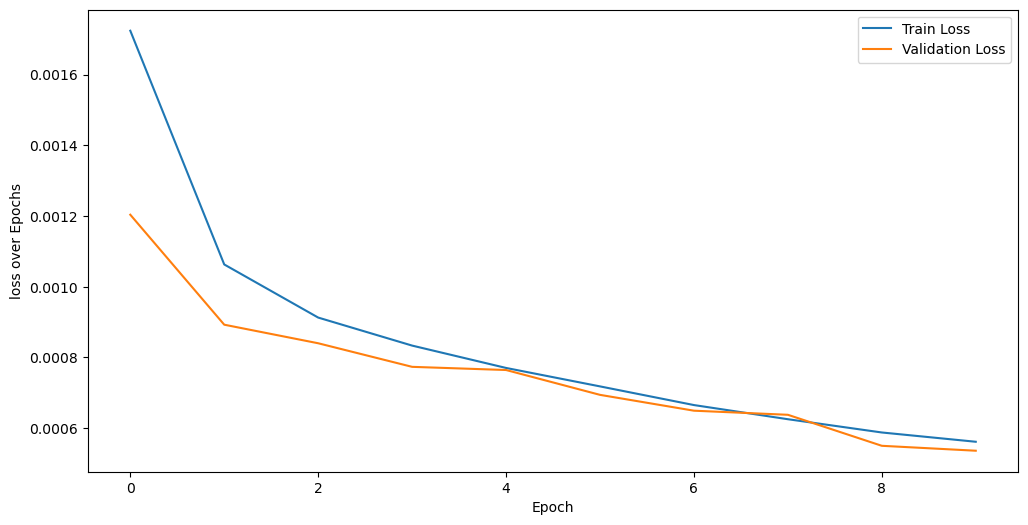

In [37]:
plt.figure(figsize=(12,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.ylabel("loss over Epochs")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [38]:
# Predicting the test dataset
model.eval()
pred_val = []
target_val = []

with torch.inference_mode():
  for x_test, y_test in test_loader:
    y_test_pred = model(x_test)
    pred_val.append(y_test_pred)
    target_val.append(y_test)

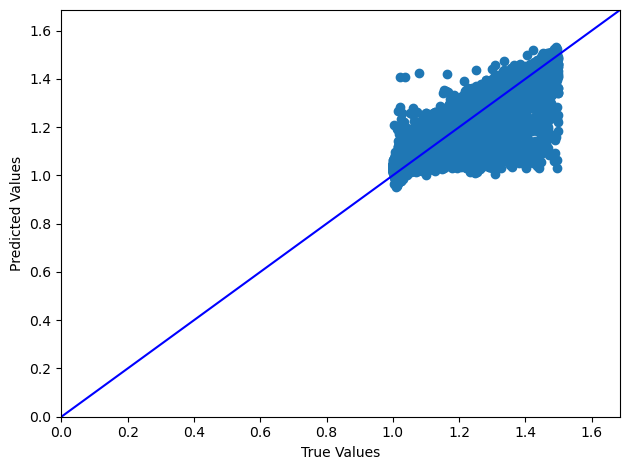

In [39]:
labels = torch.cat(target_val).flatten().tolist()
predictions = torch.cat(pred_val).flatten().tolist()

plt.scatter(labels, predictions)

max_lim = max(max(predictions), max(labels))
max_lim += max_lim * 0.1

plt.xlim(0, max_lim)
plt.ylim(0, max_lim)

plt.plot([0,max_lim], [0,max_lim], "b-")

plt.xlabel("True Values") 
plt.ylabel("Predicted Values")
plt.tight_layout()
